# About this notebook
- This notebook is to model the Covid-19 cases for all counties in US based on the county-level demographic and economic data
- The Covid-19 data are downloaded from JHU-CSSEGIS (https://github.com/CSSEGISandData/COVID-19)
- The county-level demographics and economy datasets are from US Census Bureau

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, findspark

spark_home = os.getenv('SPARK_HOME')
findspark.init(spark_home)

In [3]:
from pyspark import SparkConf
sc = SparkConf()

from pyspark.sql import SparkSession
spark = SparkSession.builder.config(conf=sc).getOrCreate()
spark

In [4]:
import sys
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
from pyspark import SparkContext
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window
from pyspark.sql import DataFrame

## Get data

In [6]:
# US Census Bureau data

df_population = spark.read.csv('data/PopulationEstimates.csv', header=True, inferSchema=True)
df_poverty = spark.read.csv('data/PovertyEstimates.csv', header=True, inferSchema=True)
df_unemployment = spark.read.csv('data/Unemployment.csv', header=True, inferSchema=True)

In [7]:
# US county data

df_counties = spark.read.csv('data/Counties.csv', header=True) \
    .select(F.col('X1').alias('state'), F.concat(F.col('X2'), F.col('X3')).alias('FIPS'), F.col('X4').alias('county'))

In [8]:
# Covid-19 related data, snapshot_date = 2020-08-01

df_confirmed = spark.read.csv('data/time_series_covid19_confirmed_US.csv', header=True, inferSchema=True) \
    .fillna(0) \
    .withColumn('FIPS', F.format_string('%05d', F.col('FIPS').cast(T.IntegerType())))

df_death = spark.read.csv('data/time_series_covid19_deaths_US.csv', header=True, inferSchema=True) \
    .fillna(0) \
    .filter('Population > 0') \
    .withColumn('FIPS', F.format_string('%05d', F.col('FIPS').cast(T.IntegerType())))

## Section 1: Process the Covid-19 and County-Level data

### Section 1a: Process the Census data

In [9]:
def process_census_data(df):
    """ process the census data (population, poverty, and unemployment) """
    
    import re
    
    # for poverty table, need to correct the schema
    if 'FIPStxt' in df.columns:
        df = df.withColumnRenamed('FIPStxt', 'FIPS')
    
    # filter only the latest (2018) data
    cols_to_keep = [col for col in df.columns if '2018' in col] + ['FIPS']
    df = df.select(cols_to_keep)

    # fillna
    df = df.fillna(0)

    # format FIPS column
    df = df.withColumn('FIPS', F.format_string('%05d', F.col('FIPS').cast(T.IntegerType())))

    # replace comma and dollar-sign in the columns
    udf_remove_comma = F.udf(lambda x: re.sub(',', '', str(x)), T.StringType())
    udf_remove_dollar = F.udf(lambda x: re.sub('\$', '',x), T.StringType())

    return df.select(*[udf_remove_dollar(udf_remove_comma(col)).alias(col) for col in df.columns])

In [10]:
df_population = process_census_data(df_population)

In [11]:
df_population.show(5)

+-----------------+--------------+-----------+-----------+----------------+----------------------+-----------------+------------+-------------+-----------------+------------+------------+------------------+------------------------+-------------------+--------------+-----+
|POP_ESTIMATE_2018|N_POP_CHG_2018|Births_2018|Deaths_2018|NATURAL_INC_2018|INTERNATIONAL_MIG_2018|DOMESTIC_MIG_2018|NET_MIG_2018|RESIDUAL_2018|GQ_ESTIMATES_2018|R_birth_2018|R_death_2018|R_NATURAL_INC_2018|R_INTERNATIONAL_MIG_2018|R_DOMESTIC_MIG_2018|R_NET_MIG_2018| FIPS|
+-----------------+--------------+-----------+-----------+----------------+----------------------+-----------------+------------+-------------+-----------------+------------+------------+------------------+------------------------+-------------------+--------------+-----+
|        327167434|       2020313|    3855500|    2814013|         1041487|                978826|                0|      978826|            0|          8091609|         0.0|       

In [12]:
df_poverty = process_census_data(df_poverty)

In [13]:
df_poverty.show(5)

+-----------+--------------+--------------+--------------+---------------+---------------+-----------+--------------+--------------+--------------+---------------+---------------+-----------+--------------+--------------+--------------+---------------+---------------+-------------+--------------+--------------+----------+-------------+-------------+-------------+--------------+--------------+-----+
|POVALL_2018|CI90LBAll_2018|CI90UBALL_2018|PCTPOVALL_2018|CI90LBALLP_2018|CI90UBALLP_2018|POV017_2018|CI90LB017_2018|CI90UB017_2018|PCTPOV017_2018|CI90LB017P_2018|CI90UB017P_2018|POV517_2018|CI90LB517_2018|CI90UB517_2018|PCTPOV517_2018|CI90LB517P_2018|CI90UB517P_2018|MEDHHINC_2018|CI90LBINC_2018|CI90UBINC_2018|POV04_2018|CI90LB04_2018|CI90UB04_2018|PCTPOV04_2018|CI90LB04P_2018|CI90UB04P_2018| FIPS|
+-----------+--------------+--------------+--------------+---------------+---------------+-----------+--------------+--------------+--------------+---------------+---------------+-----------+-----

In [14]:
df_unemployment = process_census_data(df_unemployment)

In [15]:
df_unemployment.show(5)

+-------------------------+-------------+---------------+----------------------+----------------------------+-----------------------------------------+-----+
|Civilian_labor_force_2018|Employed_2018|Unemployed_2018|Unemployment_rate_2018|Median_Household_Income_2018|Med_HH_Income_Percent_of_State_Total_2018| FIPS|
+-------------------------+-------------+---------------+----------------------+----------------------------+-----------------------------------------+-----+
|                161640488|    155344043|        6296445|                   3.9|                      61937 |                                      0.0|00000|
|                  2198837|      2112347|          86490|                   3.9|                      49881 |                                    100.0|01000|
|                    25957|        25015|            942|                   3.6|                      59338 |                                    119.0|01001|
|                    93849|        90456|           

### Section 1b: Process the Covid-19 data

In [16]:
# join df_confirmed and df_death dataframes to make a master table

df_us = df_confirmed.select('FIPS', 'Combined_Key', F.col(df_confirmed.columns[-1]).alias('confirmed_cases')) \
.join(df_death.select('FIPS', 'Combined_Key', 'Population', F.col(df_death.columns[-1]).alias('death_cases')),
      on=['FIPS', 'Combined_Key'])

In [17]:
# compute infection rates
df_us = df_us \
    .withColumn('Infection_Rate', F.round(F.col('confirmed_cases')/F.col('Population'), 5)) \
    .withColumn('Fatality_Rate', F.round(F.col('death_cases')/F.col('confirmed_cases'), 5)) \
    .withColumnRenamed('Combined_Key', 'County')

In [18]:
# join with df_counties to get the state column

df_us = df_us \
    .join(df_counties.select('FIPS', 'state'), on='FIPS')

In [19]:
df_us.printSchema()

root
 |-- FIPS: string (nullable = false)
 |-- County: string (nullable = true)
 |-- confirmed_cases: integer (nullable = true)
 |-- Population: integer (nullable = true)
 |-- death_cases: integer (nullable = true)
 |-- Infection_Rate: double (nullable = true)
 |-- Fatality_Rate: double (nullable = true)
 |-- state: string (nullable = true)



### Section 1c: Join the Covid-19 table and the County-level data table

In [20]:
df_us = df_us \
    .join(df_population, on='FIPS') \
    .join(df_poverty, on='FIPS') \
    .join(df_unemployment, on='FIPS')

In [21]:
df_us.printSchema()

root
 |-- FIPS: string (nullable = false)
 |-- County: string (nullable = true)
 |-- confirmed_cases: integer (nullable = true)
 |-- Population: integer (nullable = true)
 |-- death_cases: integer (nullable = true)
 |-- Infection_Rate: double (nullable = true)
 |-- Fatality_Rate: double (nullable = true)
 |-- state: string (nullable = true)
 |-- POP_ESTIMATE_2018: string (nullable = true)
 |-- N_POP_CHG_2018: string (nullable = true)
 |-- Births_2018: string (nullable = true)
 |-- Deaths_2018: string (nullable = true)
 |-- NATURAL_INC_2018: string (nullable = true)
 |-- INTERNATIONAL_MIG_2018: string (nullable = true)
 |-- DOMESTIC_MIG_2018: string (nullable = true)
 |-- NET_MIG_2018: string (nullable = true)
 |-- RESIDUAL_2018: string (nullable = true)
 |-- GQ_ESTIMATES_2018: string (nullable = true)
 |-- R_birth_2018: string (nullable = true)
 |-- R_death_2018: string (nullable = true)
 |-- R_NATURAL_INC_2018: string (nullable = true)
 |-- R_INTERNATIONAL_MIG_2018: string (nullable =

In [22]:
# convert this master table to Pandas for futher modeling

pd_us = df_us.toPandas()

## Section 2: Feature Analysis

In [23]:
# replace 'None' to 0

pd_us = pd_us.replace('None', 0)

In [24]:
# fillna

pd_us = pd_us.fillna(0)

In [25]:
# convert the data type into float

X = pd_us.iloc[:, 8:].astype('double')
Y = pd_us['confirmed_cases']

In [26]:
X.head()

,POP_ESTIMATE_2018,N_POP_CHG_2018,Births_2018,Deaths_2018,NATURAL_INC_2018,INTERNATIONAL_MIG_2018,DOMESTIC_MIG_2018,NET_MIG_2018,RESIDUAL_2018,GQ_ESTIMATES_2018,...,CI90UB04_2018,PCTPOV04_2018,CI90LB04P_2018,CI90UB04P_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018
0,55601.0,158.0,655.0,532.0,123.0,-2.0,37.0,35.0,0.0,455.0,...,0.0,0.0,0.0,0.0,25957.0,25015.0,942.0,3.6,59338.0,119.0
1,218022.0,5403.0,2254.0,2228.0,26.0,118.0,5232.0,5350.0,27.0,2190.0,...,0.0,0.0,0.0,0.0,93849.0,90456.0,3393.0,3.6,57588.0,115.5
2,24881.0,-277.0,261.0,324.0,-63.0,12.0,-227.0,-215.0,1.0,2820.0,...,0.0,0.0,0.0,0.0,8373.0,7940.0,433.0,5.2,34382.0,68.9
3,22400.0,-155.0,250.0,256.0,-6.0,10.0,-158.0,-148.0,-1.0,2151.0,...,0.0,0.0,0.0,0.0,8661.0,8317.0,344.0,4.0,46064.0,92.3
4,57840.0,13.0,681.0,662.0,19.0,8.0,-10.0,-2.0,-4.0,489.0,...,0.0,0.0,0.0,0.0,25006.0,24128.0,878.0,3.5,50412.0,101.1


In [27]:
Y.head()

0     972
1    3056
2     550
3     355
4     685
Name: confirmed_cases, dtype: int32

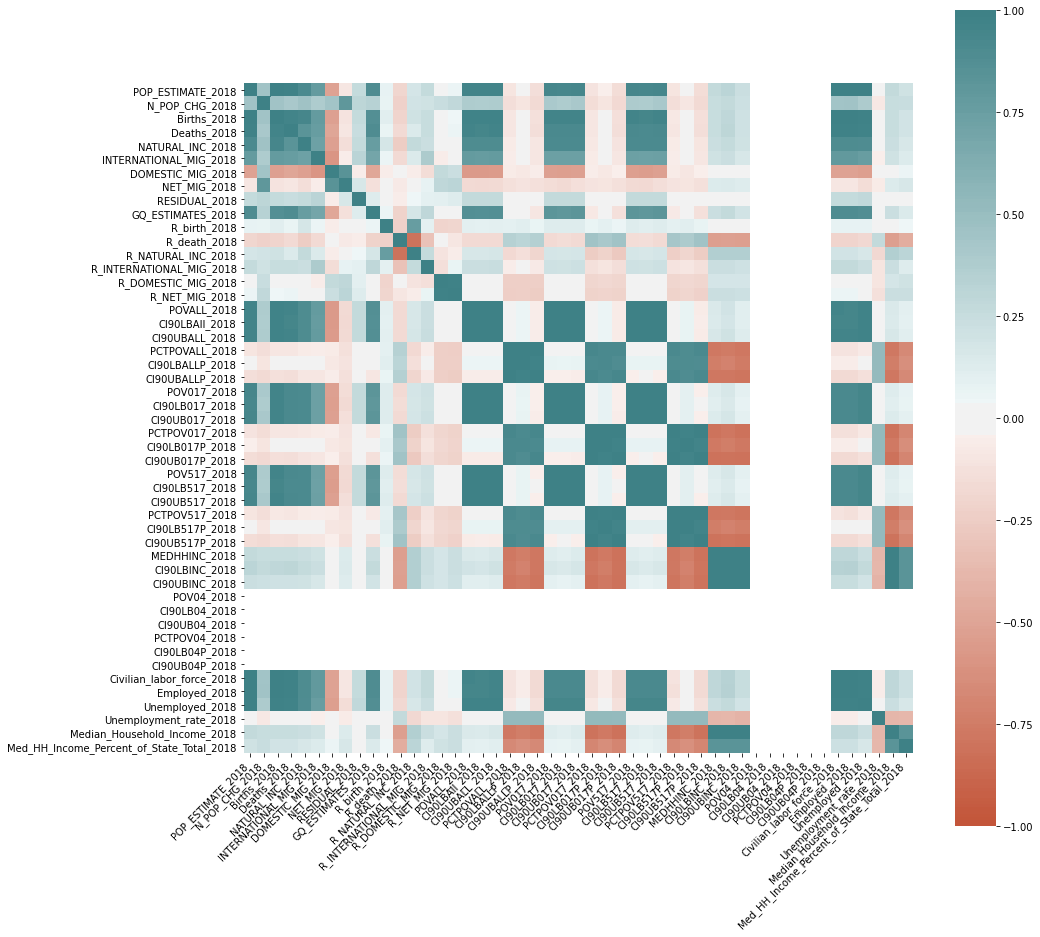

In [28]:
# feature correlation

corr = X.corr()

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 200, n=200), square=True);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

## Section 3: Feature Selection via LASSO Regression

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

In [30]:
# scale the data

scaler = StandardScaler()
X[X.columns] = pd.DataFrame(scaler.fit_transform(X[X.columns]))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X[Y>0], Y[Y>0], test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

(2466, 49) (617, 49)


In [32]:
# feature selection via Lasso regression

sel_ = SelectFromModel(Lasso(alpha=0.1))
sel_.fit(X_train.values, np.log10(y_train.values))

SelectFromModel(estimator=Lasso(alpha=0.1))

In [33]:
# get features that are kept by Lasso regression

selected_feat = X_train.columns[(sel_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_ == 0)))

total features: 49
selected features: 9
features with coefficients shrank to zero: 40


In [34]:
removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats

Index(['POP_ESTIMATE_2018', 'Births_2018', 'NATURAL_INC_2018',
       'INTERNATIONAL_MIG_2018', 'DOMESTIC_MIG_2018', 'NET_MIG_2018',
       'RESIDUAL_2018', 'R_death_2018', 'R_INTERNATIONAL_MIG_2018',
       'R_DOMESTIC_MIG_2018', 'R_NET_MIG_2018', 'POVALL_2018',
       'CI90LBAll_2018', 'CI90UBALL_2018', 'PCTPOVALL_2018', 'CI90UBALLP_2018',
       'POV017_2018', 'CI90LB017_2018', 'CI90UB017_2018', 'PCTPOV017_2018',
       'CI90LB017P_2018', 'CI90UB017P_2018', 'POV517_2018', 'CI90LB517_2018',
       'CI90UB517_2018', 'PCTPOV517_2018', 'CI90UB517P_2018', 'MEDHHINC_2018',
       'CI90UBINC_2018', 'POV04_2018', 'CI90LB04_2018', 'CI90UB04_2018',
       'PCTPOV04_2018', 'CI90LB04P_2018', 'CI90UB04P_2018',
       'Civilian_labor_force_2018', 'Employed_2018', 'Unemployed_2018',
       'Unemployment_rate_2018', 'Median_Household_Income_2018'],
      dtype='object')

## Section 5: XGBoost with selected features

In [35]:
# select features

X_train_sel = X_train[selected_feat]
X_test_sel = X_test[selected_feat]

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

In [37]:
# set up the XGBRegressor and the parameter space

reg = XGBRegressor(n_estimators=500)

param_dist = {
    'max_depth' : np.arange(5, 10),
    'colsample_bytree' : np.arange(0.6, 1.0, 1),
    'subsample' : np.arange(0.6, 1.0, 1),
    'eta' : np.logspace(-2, 0, 10)
}

In [38]:
# set up how many random searches to do

n_iter_search = 20

In [39]:
# set up the random search

random_search = RandomizedSearchCV(
    reg,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    cv=5,
    scoring='neg_mean_squared_error'
)

In [40]:
# search!

random_search.fit(
    X_train_sel,
    np.log10(y_train.values),
    eval_metric='rmse',
    eval_set=[(X_train_sel, np.log10(y_train.values)), (X_test_sel, np.log10(y_test.values))],
    verbose=5,
    early_stopping_rounds=10
)

[08:51:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.79633	validation_1-rmse:1.78481
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[5]	validation_0-rmse:1.11267	validation_1-rmse:1.12478
[10]	validation_0-rmse:0.719584	validation_1-rmse:0.747908
[15]	validation_0-rmse:0.502846	validation_1-rmse:0.553392
[20]	validation_0-rmse:0.381153	validation_1-rmse:0.45222
[25]	validation_0-rmse:0.320808	validation_1-rmse:0.404822
[30]	validation_0-rmse:0.288117	validation_1-rmse:0.383866
[35]	validation_0-rmse:0.267896	validation_1-rmse:0.375284
[40]	validation_0-rmse:0.257185	validation_1-rmse:0.37179
[45]	validation_0-rmse:0.247455	validation_1-rmse:0.369188
[50]	validation_0-rmse:0.239644	validation_1-rmse:0.367232
[55]	validation_0-rmse:0.233112	validation_1-rmse:0.366494
[60]	validation_0-rmse:0.

RandomizedSearchCV(cv=5, estimator=XGBRegressor(n_estimators=500), n_iter=20,
                   param_distributions={'colsample_bytree': array([0.6]),
                                        'eta': array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ]),
                                        'max_depth': array([5, 6, 7, 8, 9]),
                                        'subsample': array([0.6])},
                   scoring='neg_mean_squared_error')

In [41]:
# the best RMSE from the search

print(f"Best MSE is {-random_search.best_score_}")

Best MSE is 0.13913418408158776


In [42]:
# the best estimator from the search

reg_best = random_search.best_estimator_

In [43]:
# look at the hyperparameters of the best model

reg_best

XGBRegressor(colsample_bytree=0.6, eta=0.01, max_depth=5, n_estimators=500,
             subsample=0.6)

## Section 6: Visualize feature importance from the XGBoost model

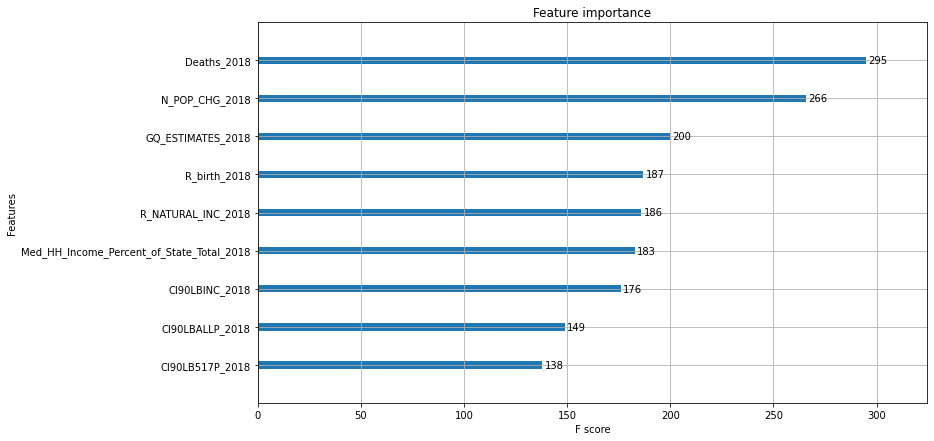

In [45]:
import xgboost as xgb

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
xgb.plot_importance(reg_best, ax=ax);

### Insight thru feature importance
- DEATHS_2018 is one critical feature, which makes sense because it implies the age of the population living in the county. It is known that it is easier for old people to be infected by Covid-19
- N_POP_CHG_2018 means the population change in 2018, which is important in this case because it implies the population liquidity in the county -- more people moving around can lead to more people infected by Covid-19